<a href="https://colab.research.google.com/github/christopher-reed/tidytuesday/blob/master/2021/week_4/TidyTuesday_Kenya_Census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3 side by side maps. Showing total population, proportion of population that farms, and avg household size. Work in progress...

In [5]:
!pip install geopandas

In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import matplotlib.cm as cm

In [7]:
df_gender = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-19/gender.csv')
df_crops = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-19/crops.csv')
df_households = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-19/households.csv')
df_kenya_counties = gpd.read_file('/content/County.shp')

# https://africaopendata.org/dataset/kenya-counties-shapefile

# Wrangle

In [8]:
#######################
## CLEAN COLUMN NAMES##
#######################

df_gender.columns = df_gender.columns.str.lower()

df_crops.columns = df_crops.columns.str.lower().str.replace(' ', '_')
df_crops = df_crops.rename(columns = {'subcounty':'county'})

df_households.columns = df_households.columns.str.lower()
df_households = df_households.rename(columns = {'numberofhouseholds':'number_of_households',
                                                'averagehouseholdsize':'average_household_size'})

df_kenya_counties.columns = df_kenya_counties.columns.str.lower()

##############################
## STANDARDIZE COUNTY NAMES ##
##############################

# Base all county names on `df_kenya_counties`
# Can find the counties that don't match the master using the following line
# [x for x in df_to_clean['county'].unique() if x not in df_kenya_counties['county'].unique()]

# Clean df_households
df_households['county'] = df_households['county'].str.replace(' ', '')

df_households['county'] = df_households['county'].replace({'TanaRiver':'Tana River',
                                                           'Taita/Taveta':'Taita Taveta',
                                                           'Tharaka-Nithi':'Tharaka',
                                                           'WestPokot':'West Pokot',
                                                           'TransNzoia':'Trans Nzoia',
                                                           'UasinGishu':'Uasin Gishu',
                                                           'Elgeyo/Marakwet':'Keiyo-Marakwet',
                                                           'NairobiCity':'Nairobi',
                                                           'HomaBay': 'Homa Bay'})

df_households = df_households[df_households['county'] != 'Kenya']

# Clean df_crops
df_crops['county'] = df_crops['county'].str.capitalize()

df_crops['county'] = df_crops['county'].replace({'Tana river':'Tana River',
                                                 'Taita/taveta':'Taita Taveta',
                                                 'Tharaka-nithi':'Tharaka',
                                                 'West pokot':'West Pokot',
                                                 'Trans nzoia':'Trans Nzoia',
                                                 'Uasin gishu':'Uasin Gishu',
                                                 'Elgeyo/marakwet':'Keiyo-Marakwet',
                                                 'Nairobi City':'Nairobi',
                                                 'Homa bay':'Homa Bay'})

df_crops = df_crops[df_crops['county'] != 'Kenya']

# Clean df_gender
df_gender['county'] = df_gender['county'].replace({'Taita/Taveta':'Taita Taveta',
                                                    'Tharaka-Nithi':'Tharaka',
                                                    'Elgeyo/Marakwet':'Keiyo-Marakwet',
                                                    'Nairobi City':'Nairobi'})

df_gender = df_gender[df_gender['county'] != 'Total']

Merge all 4 dfs together.

In [9]:
############################
## MERGE ALL DFS TOGETHER ##
############################

# Remove some excess columns before the merge
df_households_dropped = df_households.drop(columns = 'population')

df_complete_data = df_kenya_counties.merge(df_households_dropped, on = 'county', how = 'inner')
df_complete_data = df_complete_data.merge(df_crops, on = 'county', how = 'inner')
df_complete_data = df_complete_data.merge(df_gender, on = 'county', how = 'inner')

#######################
## CALCULATED FIELDS ##
#######################

# What prop of population is farming?
df_complete_data['prop_farming'] = df_complete_data['farming'] / df_complete_data['total']

# Total population in 100,000s
df_complete_data['population_hundred_thousand'] = df_complete_data['total'] / 100000

# Inspect
df_complete_data.head()

,objectid,area,perimeter,county3_,county3_id,county,shape_leng,shape_area,geometry,number_of_households,average_household_size,farming,tea,coffee,avocado,citrus,mango,coconut,macadamia,cashew_nut,khat_(miraa),male,female,intersex,total,prop_farming,population_hundred_thousand
0,1,5.677,15.047,2.0,1.0,Turkana,15.046838,5.676985,"POLYGON ((35.79593 5.34449, 35.79659 5.34468, ...",164519,5.6,61209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,478087,448868,21,926976,0.066031,9.26976
1,2,6.177,11.974,3.0,2.0,Marsabit,11.974165,6.176831,"POLYGON ((36.05061 4.45622, 36.23184 4.45124, ...",77495,5.8,39167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243548,216219,18,459785,0.085185,4.59785
2,3,2.117,7.355,4.0,3.0,Mandera,7.355154,2.117196,"POLYGON ((41.62133 3.97673, 41.62272 3.97860, ...",125763,6.9,62639,NaN,NaN,NaN,NaN,2685.0,NaN,NaN,NaN,NaN,434976,432444,37,867457,0.072210,8.67457
3,4,4.610,9.838,5.0,4.0,Wajir,9.838408,4.609589,"POLYGON ((39.31812 3.47197, 39.31956 3.47168, ...",127932,6.1,63433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415374,365840,49,781263,0.081193,7.81263
4,5,0.740,5.030,6.0,5.0,West Pokot,5.030271,0.740481,"POLYGON ((35.12745 2.62271, 35.12762 2.62302, ...",116182,5.3,89828,NaN,1026.0,7535.0,1173.0,4426.0,NaN,NaN,NaN,NaN,307013,314213,15,621241,0.144594,6.21241


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Use the colorbar set_ticks() method instead.


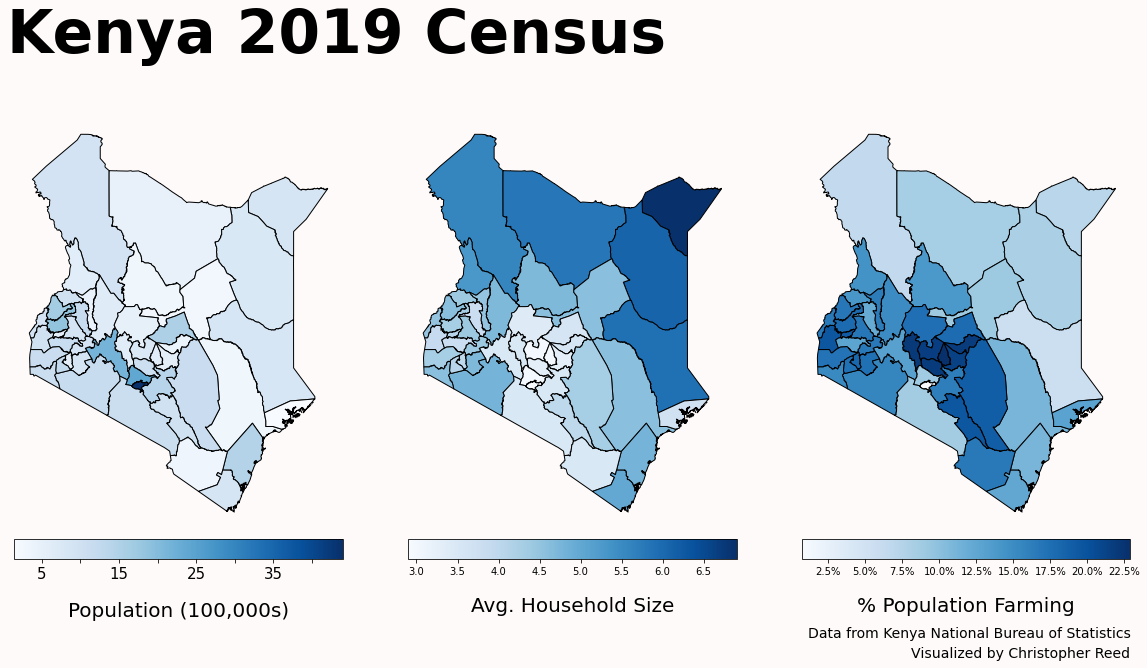

In [14]:
# For reference: https://geopandas.org/mapping.html

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20,20))


divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('bottom',
                            size = '5%',
                            pad=0.1)


divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

df_complete_data.plot(column = 'population_hundred_thousand',
                      # vmin = 0,
                      # vmax = 50,
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'Blues',
                      ax = ax1,
                      cax = cax1,
                      legend_kwds = {'orientation':'horizontal'})

df_complete_data.plot(column = 'average_household_size',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'Blues',
                      ax = ax2,
                      cax = cax2,
                      legend_kwds = {'orientation':'horizontal'})

df_complete_data.plot(column = 'prop_farming',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'Blues',
                      ax = ax3,
                      cax = cax3,
                      legend_kwds = {'orientation':'horizontal'})
##################
## PLOT LEGENDS ##
##################

cax1.set_xlabel('Population (100,000s)', fontsize = 20, labelpad = 20)
cax2.set_xlabel('Avg. Household Size', fontsize = 20, labelpad = 20)
cax3.set_xlabel('% Population Farming', fontsize = 20, labelpad = 20)

cax3.xaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

cax1.set_xticks([40])
cax1.set_xticklabels(['5','','15', '', '25', '', '35'], fontdict = {'fontsize':15} )

##########
## TEXT ##
##########

fig.text(x = 0.12, y = 0.7, s = 'Kenya 2019 Census',fontsize = 60, weight = 'heavy')
fig.text(x = 0.9, y = 0.28, s = 'Data from Kenya National Bureau of Statistics\nVisualized by Christopher Reed', ha = 'right', fontsize = 14, linespacing = 1.5)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

fig.set_facecolor('snow')

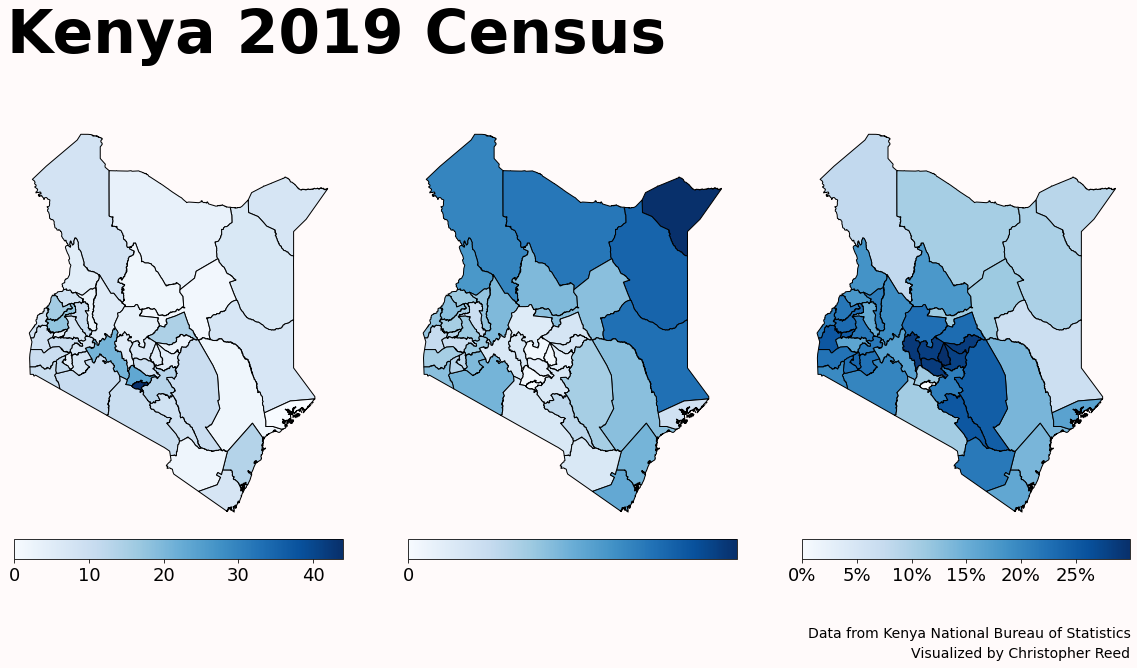

In [35]:
# For reference: https://geopandas.org/mapping.html
# For colobar formatting: https://medium.com/python-in-plain-english/mapping-with-pythons-geopandas-2869bb758b08

fig, (ax_pop, ax_house, ax_farm) = plt.subplots(nrows = 1, ncols = 3, figsize = (20,20))

#####################
## POPULATION MAP  ##
#####################

# Geopandas plot
df_complete_data.plot(column = 'population_hundred_thousand',
                      edgecolor = 'black',
                      cmap = 'Blues',
                      ax = ax_pop)

# Set axis for colorbar
divider_pop = make_axes_locatable(ax_pop)
cax_pop = divider_pop.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

# Make color bar
vmax_pop = df_complete_data['population_hundred_thousand'].max()
mappable_pop = plt.cm.ScalarMappable(cmap = 'Blues',
                                      norm = plt.Normalize(vmin = 0, vmax = vmax_pop))
cbar_pop = fig.colorbar(mappable_pop, cax = cax_pop, orientation = 'horizontal')

# Format color bar using normal matplotlib style
cbar_pop.set_ticks(np.arange(0,vmax_pop, 10))
cbar_pop.ax.tick_params(labelsize = 18)

###################
## HOUSEHOLD MAP ##
###################

# Geopandas plot
df_complete_data.plot(column = 'average_household_size',
                      edgecolor = 'black',
                      cmap = 'Blues',
                      ax = ax_house)

# Set axis for colorbar
divider_house = make_axes_locatable(ax_house)
cax_house = divider_house.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

# Make color bar
vmax_house = df_complete_data['average_household_size'].max()
mappable_house = plt.cm.ScalarMappable(cmap = 'Blues',
                                       norm = plt.Normalize(vmin = 0, vmax = vmax_house))
cbar_house = fig.colorbar(mappable_house, cax = cax_house, orientation = 'horizontal')

# Format color bar using normal matplotlib style
cbar_house.set_ticks(np.arange(0,vmax_house, 10))
cbar_house.ax.tick_params(labelsize = 18)


######################
## PROP FARMING MAP ##
######################

# Geopandas plot
df_complete_data.plot(column = 'prop_farming',
                      edgecolor = 'black',
                      cmap = 'Blues',
                      ax = ax_farm)

# Set axis for colorbar
divider_farm = make_axes_locatable(ax_farm)
cax_farm = divider_farm.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

# Make color bar
# vmax_farm = df_complete_data['prop_farming'].max()
vmax_farm = 0.30
mappable_farm = plt.cm.ScalarMappable(cmap = 'Blues',
                                      norm = plt.Normalize(vmin = 0, vmax = vmax_farm))
cbar_farm = fig.colorbar(mappable_farm, cax = cax_farm, orientation = 'horizontal', format = ticker.PercentFormatter(xmax = 1, decimals = 0))

# Format color bar using normal matplotlib style
cbar_farm.set_ticks(np.arange(0,vmax_farm, 0.05))
cbar_farm.ax.tick_params(labelsize = 18)
# cbar_farm.xaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))



##########
## TEXT ##
##########

fig.text(x = 0.12, y = 0.7, s = 'Kenya 2019 Census',fontsize = 60, weight = 'heavy')
fig.text(x = 0.9, y = 0.28, s = 'Data from Kenya National Bureau of Statistics\nVisualized by Christopher Reed', ha = 'right', fontsize = 14, linespacing = 1.5)

ax_pop.axis('off')
ax_house.axis('off')
ax_farm.axis('off')

fig.set_facecolor('snow')

In [29]:
vmax_farm

0.22913414076745012